In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from netCDF4 import Dataset, num2date
import os
import random
import copy
import csv
import pandas as pd
from ViT_Unpatch import ViT

# --------------------
# General Setup
# --------------------

deBug = True
seed_num = 1
np.random.seed(seed_num)
random.seed(seed_num)
torch.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)
torch.cuda.is_available()
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")
model_leadTms = "FullField2SmallPatch"
lead_time_width = 2

# --------------------
# Data Directories
# --------------------
mdl_directory = "/gpfs/gibbs/project/lu_lu/ax59/MJO_Project/Data/AllLeadTms/"
mdl_out_dir = "Result_01/"
obs_directory = "/gpfs/gibbs/project/lu_lu/ax59/MJO_Project/Data/AllLeadTms/"
obs_out_dir = "Result_02/"
bcor_directory = "Result_03/"
time_dir = "Data/Time/"

In [11]:
# --------------------
# Section 0: Class and Helper Function Definitions
# --------------------

class MDLDataset(torch.utils.data.Dataset):
    def __init__(self, mdl_dir, time_dir, lead_time):
        print("Loading MDL dataset into memory (NumPy arrays)...")
        self.width = lead_time
        # Load Features and Conditioning into NumPy arrays 
        features = []
        variable_names = ["TMQ", "FLUT", "U200", "U850", "TREFHT"]
        
        # Load data
        lead_time_vars = []
        for var_name in variable_names:
            file_path = os.path.join(mdl_dir, f"CML2025_Step0C_TROP30_MDL_remapped_90x180_daily_DJFM_Anom_nonFltr_{var_name}_leadTm1.nc")
            with Dataset(file_path) as f:
                lead_time_vars.append(f.variables[var_name][:])
            
        # Stack variables along a new channel dimension -> (samples, vars, lat, lon)
        features = np.stack(lead_time_vars, axis=1)

        # Concatenate all lead times into single large NumPy arrays
        self.features = features
        
        print(f"MDL dataset loaded. Total samples: {len(self.features)}")

    def __len__(self):
        return len(self.features) - self.width

    def __getitem__(self, idx):
        # Retrieve the data as NumPy arrays
        
        features = self.features[idx]
        targets = self.features[idx+self.width]
        
        # Convert only this specific sample to a tensor before returning
        return (
            torch.tensor(features, dtype=torch.float32),
            torch.tensor(targets, dtype=torch.float32)
        )

class OBSDataset(torch.utils.data.Dataset):
    def __init__(self, obs_dir, time_dir, lead_time, indices=None):
        print("Loading OBS dataset into memory (NumPy arrays)...")
        self.width = lead_time

        # --- Load all data into full NumPy arrays first ---
        with Dataset(os.path.join(obs_dir, "CML2025_Step0C_OBS_remapped_90x180_daily_DJFM_nonFltr_PC1.nc")) as f:
            pc1 = f.variables["PC1"][:]
        with Dataset(os.path.join(obs_dir, "CML2025_Step0C_OBS_remapped_90x180_daily_DJFM_nonFltr_PC2.nc")) as f:
            pc2 = f.variables["PC2"][:]
        self.targets_np = np.stack([pc1, pc2], axis=-1)

        features = []
        variable_names = ["tcwv", "olr", "u200", "u850", "trefht"]

        lead_time_vars = []
        for i, var_name in enumerate(variable_names):
            file_path = os.path.join(obs_dir, f"CML2025_Step0C_TROP30_OBS_remapped_90x180_daily_DJFM_Anom_nonFltr_{var_name}_leadTm1.nc")
            with Dataset(file_path) as f:
                lead_time_vars.append(f.variables[var_name][:])
        
        features = np.stack(lead_time_vars, axis=1)

        # --- Filter by indices if provided to create the final dataset ---
        if indices is not None:
            self.features = features[indices]
            self.times = time_data[indices]
            print(f"OBS dataset subset loaded. Total samples: {len(self.features)-self.width}")
        else:
            self.features = features
            self.times = time_data
            print(f"OBS dataset loaded. Total samples: {len(self.features)-self.width}")

    def __len__(self):
        return len(self.features) - self.width

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.features[idx + self.width]

        # Convert only this specific sample to a tensor before returning
        return (
            torch.tensor(features, dtype=torch.float32),
            torch.tensor(targets, dtype=torch.float32),
        )

In [12]:
from netCDF4 import Dataset, num2date # Make sure to import num2date

class OBSDataset(torch.utils.data.Dataset):
    def __init__(self, obs_dir, time_dir, lead_time, indices=None):
        print("Loading OBS dataset into memory (NumPy arrays)...")
        self.width = lead_time

        # OBS uses different variable names in the filenames
        variable_names = ["tcwv", "olr", "u200", "u850", "trefht"]
        time_objects = None # Variable to store the datetime objects

        lead_time_vars = []
        for i, var_name in enumerate(variable_names):
            file_path = os.path.join(obs_dir, f"CML2025_Step0C_TROP30_OBS_remapped_90x180_daily_DJFM_Anom_nonFltr_{var_name}_leadTm1.nc")
            with Dataset(file_path) as f:
                lead_time_vars.append(f.variables[var_name][:])
                
                # Load time data and convert to datetime objects (only once)
                if i == 0:
                    time_var = f.variables['time']
                    time_values = time_var[:]
                    time_units = time_var.units
                    time_calendar = time_var.calendar
                    # This line performs the conversion to datetime objects
                    time_objects = num2date(time_values, units=time_units, calendar=time_calendar)
        
        features = np.stack(lead_time_vars, axis=1)

        # Filter by indices if provided to create the final dataset
        if indices is not None:
            self.features = features[indices]
            self.times = time_objects[indices] # Also filter the time data
            print(f"OBS dataset subset loaded. Total samples: {len(self.features)-self.width}")
        else:
            self.features = features
            self.times = time_objects # Store the full array of datetime objects
            print(f"OBS dataset loaded. Total samples: {len(self.features)-self.width}")

    def __len__(self):
        return len(self.features) - self.width

    def __getitem__(self, idx):
        # Retrieve the data slices
        features = self.features[idx]
        targets = self.features[idx + self.width]
        
        # Retrieve the corresponding datetime objects
        feature_time = self.times[idx]
        target_time = self.times[idx + self.width]
        
        # Return everything, including the datetime objects
        return (
            torch.tensor(features, dtype=torch.float32),
            torch.tensor(targets, dtype=torch.float32),
            feature_time,
            target_time
        )

In [22]:
from netCDF4 import Dataset, num2date
import numpy as np
import torch
import os
from datetime import timedelta

class MDLDataset(torch.utils.data.Dataset):
    def __init__(self, mdl_dir, time_dir, lead_time):
        print("Loading MDL dataset and processing independent runs...")
        self.width = lead_time
        
        # --- 1. Load all data from files (in file order) ---
        variable_names = ["TMQ", "FLUT", "U200", "U850", "TREFHT"]
        time_objects = None
        lead_time_vars = []
        
        for i, var_name in enumerate(variable_names):
            file_path = os.path.join(mdl_dir, f"CML2025_Step0C_TROP30_MDL_remapped_90x180_daily_DJFM_Anom_nonFltr_{var_name}_leadTm1.nc")
            with Dataset(file_path) as f:
                lead_time_vars.append(f.variables[var_name][:])
                if i == 0:
                    time_var = f.variables['time']
                    time_objects = num2date(time_var[:], units=time_var.units, calendar=time_var.calendar)
                    
        all_features_raw = np.stack(lead_time_vars, axis=1)
        # We MUST use the raw, unsorted time objects to find the run boundaries
        self.times = time_objects 
        print(f"MDL raw data loaded. {len(all_features_raw)} total entries.")

        # --- 2. Find the boundaries of each independent run ---
        # A "run boundary" is where the time nonsensically jumps backward.
        run_boundaries = np.where(self.times[1:] < self.times[:-1])[0]
        
        # Create a list of start/end indices for each run
        run_chunks_indices = []
        start_idx = 0
        for boundary_idx in run_boundaries:
            end_idx = boundary_idx + 1 # The chunk includes this index
            run_chunks_indices.append((start_idx, end_idx))
            start_idx = end_idx # The next chunk starts after the boundary
        run_chunks_indices.append((start_idx, len(all_features_raw))) # Add the last run
        
        print(f"Found {len(run_chunks_indices)} independent runs in the file.")

        # --- 3. Process each run independently ---
        self.valid_pairs = []
        for run_start, run_end in run_chunks_indices:
            # Get the data for just this one run
            run_features = all_features_raw[run_start:run_end]
            run_times = self.times[run_start:run_end]

            # --- 4. Find seasonal gaps *within* this single run ---
            chunk_start_idx_seasonal = 0
            if len(run_times) < 2: continue # Skip if the run is too short

            # Seasonal gaps are where time jumps forward by more than 1 day
            seasonal_gaps = np.where((run_times[1:] - run_times[:-1]).astype('timedelta64[D]').astype(int) > 1)[0]
            
            chunk_end_indices_seasonal = list(seasonal_gaps)
            chunk_end_indices_seasonal.append(len(run_times) - 1) # Add the end of the run

            for gap_idx_seasonal in chunk_end_indices_seasonal:
                chunk_end_slice = gap_idx_seasonal + 1
                
                season_features = run_features[chunk_start_idx_seasonal:chunk_end_slice]
                season_times = run_times[chunk_start_idx_seasonal:chunk_end_slice]
                
                # --- 5. Create valid pairs *within* this seasonal chunk ---
                num_in_season = len(season_features)
                for i in range(num_in_season - self.width):
                    feature = season_features[i]
                    target = season_features[i + self.width]
                    feature_time = season_times[i]
                    target_time = season_times[i + self.width]
                    self.valid_pairs.append((feature, target, feature_time, target_time))
                
                chunk_start_idx_seasonal = gap_idx_seasonal + 1

        print(f"MDL dataset fully processed. Found {len(self.valid_pairs)} valid input-target pairs across all runs.")

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, idx):
        feature, target, feature_time, target_time = self.valid_pairs[idx]
        
        return (
            torch.tensor(feature, dtype=torch.float32),
            torch.tensor(target, dtype=torch.float32),
            feature_time,
            target_time
        )

In [10]:
from netCDF4 import Dataset, num2date
import numpy as np
import torch
import os

class OBSDataset(torch.utils.data.Dataset):
    def __init__(self, obs_dir, time_dir, lead_time, indices=None):
        print("Loading OBS dataset and processing seasonal chunks...")
        self.width = lead_time

        # --- 1. Load all data from files ---
        variable_names = ["tcwv", "olr", "u200", "u850", "trefht"]
        time_objects = None
        lead_time_vars = []
        
        for i, var_name in enumerate(variable_names):
            file_path = os.path.join(obs_dir, f"CML2025_Step0C_TROP30_OBS_remapped_90x180_daily_DJFM_Anom_nonFltr_{var_name}_leadTm1.nc")
            with Dataset(file_path) as f:
                lead_time_vars.append(f.variables[var_name][:])
                if i == 0:
                    time_var = f.variables['time']
                    time_objects = num2date(time_var[:], units=time_var.units, calendar=time_var.calendar)
        
        all_features_full = np.stack(lead_time_vars, axis=1)
        all_times_full = time_objects

        # --- 2. Apply subsetting indices FIRST (for k-fold CV) ---
        if indices is not None:
            all_features = all_features_full[indices]
            # --- FIX IS HERE ---
            # Assign to self.times, not a local variable
            self.times = all_times_full[indices] 
            print(f"OBS dataset subset applied. Processing {len(all_features)} time steps for this fold.")
        else:
            all_features = all_features_full
            # --- FIX IS HERE ---
            # Assign to self.times, not a local variable
            self.times = all_times_full
            print(f"OBS dataset loaded. Processing {len(all_features)} time steps.")

        # --- 3. Find gaps and create continuous chunks ---
        self.valid_pairs = []
        chunk_start_idx = 0
        
        if len(self.times) == 0:
            print("Warning: No data to process (empty indices). Dataset will be empty.")
            return

        # Find gaps using the self.times attribute
        gaps = np.where((self.times[1:] - self.times[:-1]).astype('timedelta64[D]').astype(int) > 1)[0]

        for gap_idx in np.append(gaps, len(self.times) - 1):
            chunk_end_idx = gap_idx + 1
            
            chunk_features = all_features[chunk_start_idx:chunk_end_idx]
            chunk_times = self.times[chunk_start_idx:chunk_end_idx] # Use self.times
            
            num_in_chunk = len(chunk_features)
            for i in range(num_in_chunk - self.width):
                feature = chunk_features[i]
                target = chunk_features[i + self.width]
                feature_time = chunk_times[i]
                target_time = chunk_times[i + self.width]
                self.valid_pairs.append((feature, target, feature_time, target_time))
            
            chunk_start_idx = chunk_end_idx
            
        print(f"OBS dataset processed. Found {len(self.valid_pairs)} valid input-target pairs.")

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, idx):
        feature, target, feature_time, target_time = self.valid_pairs[idx]
        
        return (
            torch.tensor(feature, dtype=torch.float32),
            torch.tensor(target, dtype=torch.float32),
            feature_time,
            target_time
        )

In [4]:
# --------------------
# Section 2: OBS Transfer Learning (as in ViT Train 2.py)
# --------------------

# General setup

mdl_model_path = mdl_out_dir + f"ViTTIMJO_FiLM_Andrew_MDL_leadTm{model_leadTms}_ensm{seed_num}.pth"

lat = 30
lon = 180
var = 5
batch_size = 121

# Calculate the total number of samples without loading the data
# We check the size of the first lead time's PC file and multiply by the number of lead times
with Dataset(obs_directory + "CML2025_Step0C_OBS_remapped_90x180_daily_DJFM_nonFltr_PC1.nc") as f:
    total_samples = len(f.variables["PC1"][:])
print(f"Total OBS samples across all lead times: {total_samples}")

indices = np.arange(total_samples)

# For each lead time, split indices into 3 folds
n = len(indices)
fold1 = indices[:n//3]
fold2 = indices[n//3:2*n//3]
fold3 = indices[2*n//3:]
folds = [fold1, fold2, fold3] # Each will be a list of indices for fold 1, 2, 3

# For each round, use one fold as test, one as val, one as train (rotate)
train_val_rounds = []
train_val_test_rounds = []
test_ts = []
val_ts = []

for i in range(3):
    test_indices = np.array(folds[i])
    val_indices = np.array(folds[(i+1)%3])
    train_indices = np.array(folds[(i+2)%3])

    # Create datasets
    train_dataset = OBSDataset(obs_directory, time_dir, lead_time_width, indices=train_indices)
    val_dataset = OBSDataset(obs_directory, time_dir, lead_time_width, indices=val_indices)
    test_dataset = OBSDataset(obs_directory, time_dir, lead_time_width, indices=test_indices)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
    test_ts.append(len(test_dataset))
    val_ts.append(len(val_dataset))
    train_val_rounds.append([train_dataloader, val_dataloader])
    train_val_test_rounds.append([train_dataloader, val_dataloader, test_dataloader])
    

Total OBS samples across all lead times: 5092
Loading OBS dataset into memory (NumPy arrays)...
OBS dataset subset loaded. Total samples: 1696
Loading OBS dataset into memory (NumPy arrays)...
OBS dataset subset loaded. Total samples: 1695
Loading OBS dataset into memory (NumPy arrays)...
OBS dataset subset loaded. Total samples: 1695
Loading OBS dataset into memory (NumPy arrays)...


/home/ax59/.conda/envs/mjo_env_1/lib/python3.13/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


OBS dataset subset loaded. Total samples: 1695
Loading OBS dataset into memory (NumPy arrays)...
OBS dataset subset loaded. Total samples: 1696
Loading OBS dataset into memory (NumPy arrays)...
OBS dataset subset loaded. Total samples: 1695
Loading OBS dataset into memory (NumPy arrays)...
OBS dataset subset loaded. Total samples: 1695
Loading OBS dataset into memory (NumPy arrays)...
OBS dataset subset loaded. Total samples: 1695
Loading OBS dataset into memory (NumPy arrays)...
OBS dataset subset loaded. Total samples: 1696


In [12]:
from datetime import timedelta

def check_time_gaps(dataset, dataset_name="Dataset"):
    """
    Iterates through a dataset's time array of datetime objects to find
    time gaps larger than 1 day.
    """
    print(f"\n--- Checking for time gaps in {dataset_name} ---")

    if not hasattr(dataset, 'times'):
        print(f"Error: The {dataset_name} object does not have a '.times' attribute.")
        return

    times = dataset.times
    gaps_found = []

    # Iterate up to the second-to-last element
    for i in range(len(times) - 1):
        time_current = times[i]
        time_next = times[i+1]
        
        # The difference between datetime objects is a timedelta
        diff = time_next - time_current

        # Check if the gap is larger than 1 day
        if diff.days > 1:
            gaps_found.append({
                "index": i,
                "last_day": time_current,
                "next_day": time_next,
                "gap_size_days": diff.days
            })

    # --- Print the Summary ---
    if not gaps_found:
        print("Verification successful! No time gaps found. The data is continuous. ✅")
    else:
        print(f"Verification FAILED! Found {len(gaps_found)} time gaps. ❌")
        print("\nDetails of gaps found:")
        for i, gap in enumerate(gaps_found):
            print(f"  Gap #{i+1}:")
            print(f"    - At index: {gap['index']}")
            print(f"    - Between {gap['last_day'].strftime('%Y-%m-%d')} and {gap['next_day'].strftime('%Y-%m-%d')}")
            print(f"    - Gap size: {gap['gap_size_days']} days")
            if i >= 10: # Don't print thousands of gaps
                print(f"    ... and {len(gaps_found) - (i+1)} more gaps ...")
                break
    
    return gaps_found

def verify_dataset_pairs(dataset, dataset_name="Dataset"):
    """
    Checks the final 'self.valid_pairs' list to ensure all pairs
    are internally correct and do not cross seasonal gaps.
    """
    print(f"\n--- Verifying the 'self.valid_pairs' in {dataset_name} ---")

    if not hasattr(dataset, 'valid_pairs') or len(dataset.valid_pairs) == 0:
        print(f"Error: The {dataset_name} has no 'self.valid_pairs' or is empty.")
        return

    # 'valid_pairs' is a list of tuples: (feature, target, feature_time, target_time)
    pair_list = dataset.valid_pairs
    
    internal_errors = 0
    
    # 1. Check every pair for correct internal spacing
    for i, pair in enumerate(pair_list):
        feature_time = pair[2]
        target_time = pair[3]
        
        diff = (target_time - feature_time).days
        
        if diff != dataset.width:
            print(f"  ❌ FAILED: Pair at index {i} has an incorrect internal gap!")
            print(f"     - Input: {feature_time.strftime('%Y-%m-%d')}")
            print(f"     - Target: {target_time.strftime('%Y-%m-%d')}")
            print(f"     - Gap: {diff} days (Expected: {dataset.width})")
            internal_errors += 1

    if internal_errors == 0:
        print("Verification 1/2 Successful: All input-target pairs are correctly spaced. ✅")
    else:
        print(f"Verification 1/2 FAILED: Found {internal_errors} incorrectly spaced pairs. ❌")


    # 2. Check the time difference *between* adjacent pairs to show seasonal jumps
    seasonal_jumps = 0
    for i in range(len(pair_list) - 1):
        # Time of the current pair's input
        time_current = pair_list[i][2] 
        # Time of the next pair's input
        time_next = pair_list[i+1][2] 
        
        diff = (time_next - time_current).days
        
        if diff > 1:
            seasonal_jumps += 1
            if seasonal_jumps <= 5: # Print details for the first 5 jumps
                print(f"\n  Note: Found a seasonal gap between pair {i} and {i+1}.")
                print(f"    - End of season on: {time_current.strftime('%Y-%m-%d')}")
                print(f"    - Start of next season on: {time_next.strftime('%Y-%m-%d')}")
                print(f"    - Gap size: {diff} days")

    if seasonal_jumps > 5:
        print(f"    ... and {seasonal_jumps - 5} more seasonal gaps (not shown) ...")
        
    print(f"\nVerification 2/2 Complete: Found {seasonal_jumps} seasonal jumps.")
    print("This is expected and shows the dataset is correctly skipping the gaps. ✅")
    print("\n--- Overall Result: The Dataset is correctly handling the gaps. ---")

In [23]:
try:
    # Instantiate the corrected MDLDataset
    mdl_dataset_full = MDLDataset(mdl_dir=mdl_directory, time_dir=time_dir, lead_time=lead_time_width)
    
    # Run the verification function
    verify_dataset_pairs(mdl_dataset_full, "Full MDL Dataset")
except Exception as e:
    print(f"An error occurred during MDL verification: {e}")

# --- Run the new verification ---
# (Assumes 'obs_dataset_full' exists from the previous cell)
if 'obs_dataset_full' in locals():
    verify_dataset_pairs(obs_dataset_full, "Full OBS Dataset")
else:
    print("Please run the 'check_time_gaps' cell first to create 'obs_dataset_full'")

Loading MDL dataset and processing independent runs...
MDL raw data loaded. 43076 total entries.
Found 8 independent runs in the file.
MDL dataset fully processed. Found 42364 valid input-target pairs across all runs.

--- Verifying the 'self.valid_pairs' in Full MDL Dataset ---
Verification 1/2 Successful: All input-target pairs are correctly spaced. ✅

  Note: Found a seasonal gap between pair 118 and 119.
    - End of season on: 0002-03-28
    - Start of next season on: 0002-11-30
    - Gap size: 247 days

  Note: Found a seasonal gap between pair 237 and 238.
    - End of season on: 0003-03-28
    - Start of next season on: 0003-11-30
    - Gap size: 247 days

  Note: Found a seasonal gap between pair 356 and 357.
    - End of season on: 0004-03-28
    - Start of next season on: 0004-11-30
    - Gap size: 247 days

  Note: Found a seasonal gap between pair 475 and 476.
    - End of season on: 0005-03-28
    - Start of next season on: 0005-11-30
    - Gap size: 247 days

  Note: Fou

In [22]:
# --- Verification for OBS Dataset ---
print("\n--- Verifying the time link in the OBS Dataset ---")

import random

try:
    # 1. Instantiate the updated OBS dataset
    obs_dataset_with_time = OBSDataset(obs_dir=obs_directory, time_dir=time_dir, lead_time=lead_time_width, indices=None)

    # 2. Get a sample
    sample_idx_obs = random.randint(0,5090)
    features, targets, feature_time, target_time = obs_dataset_with_time[sample_idx_obs]

    # 3. Print dates and check the difference
    print(f"Verifying OBS sample #{sample_idx_obs}:")
    print(f"  - Input feature date: {feature_time.strftime('%Y-%m-%d')}")
    print(f"  - Target date:        {target_time.strftime('%Y-%m-%d')}")

    time_difference_obs = (target_time - feature_time).days
    print(f"  - Calculated difference: {time_difference_obs} days")
    print(f"  - Expected difference:   {lead_time_width} days")

    if time_difference_obs == lead_time_width:
        print("  - Result: Verification successful! ✅")
    else:
        print("  - Result: Verification FAILED! ❌")

except Exception as e:
    print(f"An error occurred during OBS verification: {e}")

try:
    # Load the full, unshuffled OBS dataset
    obs_dataset_full = OBSDataset(obs_dir=obs_directory, time_dir=time_dir, lead_time=lead_time_width, indices=None)
    
    # Run the gap check on the OBS data
    check_time_gaps(obs_dataset_full, "Full OBS Dataset")

except Exception as e:
    print(f"An error occurred during OBS verification: {e}")


--- Verifying the time link in the OBS Dataset ---
Loading OBS dataset into memory (NumPy arrays)...
OBS dataset loaded. Total samples: 5090
Verifying OBS sample #965:
  - Input feature date: 1988-03-26
  - Target date:        1988-03-28
  - Calculated difference: 2 days
  - Expected difference:   2 days
  - Result: Verification successful! ✅
Loading OBS dataset into memory (NumPy arrays)...
OBS dataset loaded. Total samples: 5090

--- Checking for time gaps in Full OBS Dataset ---
Verification FAILED! Found 41 time gaps. ❌

Details of gaps found:
  Gap #1:
    - At index: 120
    - Between 1981-03-30 and 1981-11-30
    - Gap size: 245 days
  Gap #2:
    - At index: 241
    - Between 1982-03-30 and 1982-11-30
    - Gap size: 245 days
  Gap #3:
    - At index: 362
    - Between 1983-03-30 and 1983-11-30
    - Gap size: 245 days
  Gap #4:
    - At index: 484
    - Between 1984-03-30 and 1984-11-30
    - Gap size: 245 days
  Gap #5:
    - At index: 605
    - Between 1985-03-30 and 1985-1

In [21]:
# --------------------
# Section 3: Plot a Comparison of Model Errors (Grouped)
# --------------------
print("\n--- Generating a comparison plot of model errors vs. ground truth ---")

# 1. Load the two trained models
model_path_1 = obs_out_dir + f"ViTTIMJO_FiLM_Andrew_OBS_leadTm{model_leadTms}_ensm{seed_num}_round1.pth"
model_path_2 = obs_out_dir + f"ViTTIMJO_FiLM_Andrew_OBS_leadTmFullField2_ensm{seed_num}_round1.pth"

if os.path.exists(model_path_1) and os.path.exists(model_path_2):
    model_1 = torch.load(model_path_1, weights_only=False, map_location=device)
    model_1.eval()
    print(f"Loaded Model 1 from {model_path_1}")

    model_2 = torch.load(model_path_2, weights_only=False, map_location=device)
    model_2.eval()
    print(f"Loaded Model 2 from {model_path_2}")

    # 2. Get a single data sample
    test_dataloader_for_plot = train_val_test_rounds[0][2]
    sample_idx = 20
    input_image, target_image = test_dataloader_for_plot.dataset[sample_idx]

    # 3. Make predictions
    with torch.no_grad():
        input_tensor = input_image.unsqueeze(0).to(device)
        predicted_tensor_1 = model_1(input_tensor)
        predicted_image_1 = predicted_tensor_1.squeeze(0).cpu()
        predicted_tensor_2 = model_2(input_tensor)
        predicted_image_2 = predicted_tensor_2.squeeze(0).cpu()

    # 4. Prepare data for plotting
    target_np = target_image.numpy()
    predicted_np_1 = predicted_image_1.numpy()
    predicted_np_2 = predicted_image_2.numpy()

    # Calculate the error for each model relative to the ground truth
    error_np_1 = predicted_np_1 - target_np
    error_np_2 = predicted_np_2 - target_np

    variable_names = ["TMQ", "FLUT", "U200", "U850", "TREFHT"]

    # Calculate a single, global color scale for both error plots
    global_max_abs_error = np.max(np.abs(np.concatenate([error_np_1, error_np_2])))

    # Create a 5x5 grid
    fig, axes = plt.subplots(5, 5, figsize=(25, 12), constrained_layout=True)
    fig.suptitle(f'Model Error Comparison for Sample #{sample_idx} (Lead Time: {lead_time_width} days)', fontsize=16)

    for i in range(5): # Loop through the 5 channels
        # Determine a common color scale for the physical fields
        vmin = min(target_np[i].min(), predicted_np_1[i].min(), predicted_np_2[i].min())
        vmax = max(target_np[i].max(), predicted_np_1[i].max(), predicted_np_2[i].max())

        # Column 0: Ground Truth
        axes[i, 0].imshow(target_np[i], cmap='jet')
        axes[i, 0].set_ylabel(variable_names[i], fontsize=12, fontweight='bold')

        # Column 1: Model 1 Prediction
        
        axes[i, 1].imshow(predicted_np_1[i], cmap='jet')

        # Column 2: Model 2 Prediction
        im_pred2 = axes[i, 2].imshow(predicted_np_2[i], cmap='jet')
        
        # Add a shared colorbar for the first 3 plots
        fig.colorbar(im_pred2, ax=axes[i, :3].tolist(), orientation='vertical', fraction=0.05, pad=0.04)
        
        # Column 3: Model 1 Error
        im_err1 = axes[i, 3].imshow(error_np_1[i], cmap='jet')
        fig.colorbar(im_err1, ax=axes[i, 3])
        
        # Column 4: Model 2 Error
        im_err2 = axes[i, 4].imshow(error_np_2[i], cmap='jet')
        fig.colorbar(im_err2, ax=axes[i, 4])

    # Set titles for the reordered column layout
    axes[0, 0].set_title("Ground Truth", fontsize=14)
    axes[0, 1].set_title("Model 1 Prediction", fontsize=14)
    axes[0, 2].set_title("Model 2 Prediction", fontsize=14)
    axes[0, 3].set_title("Error (M1 - Truth)", fontsize=14)
    axes[0, 4].set_title("Error (M2 - Truth)", fontsize=14)

    # Remove ticks for clarity
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.savefig(bcor_directory + f"model_error_comparison_grouped_example_lead{lead_time_width}.png")
    plt.show()

else:
    print(f"Could not find one or both trained models. Please ensure both exist:")
    print(f"Model 1: {model_path_1}")
    print(f"Model 2: {model_path_2}")


--- Generating a comparison plot of model errors vs. ground truth ---
Loaded Model 1 from Result_02/ViTTIMJO_FiLM_Andrew_OBS_leadTmFullField2SmallPatch_ensm1_round1.pth
Loaded Model 2 from Result_02/ViTTIMJO_FiLM_Andrew_OBS_leadTmFullField2_ensm1_round1.pth


NameError: name 'train_val_test_rounds' is not defined


--- Generating plot of the difference in absolute errors ---


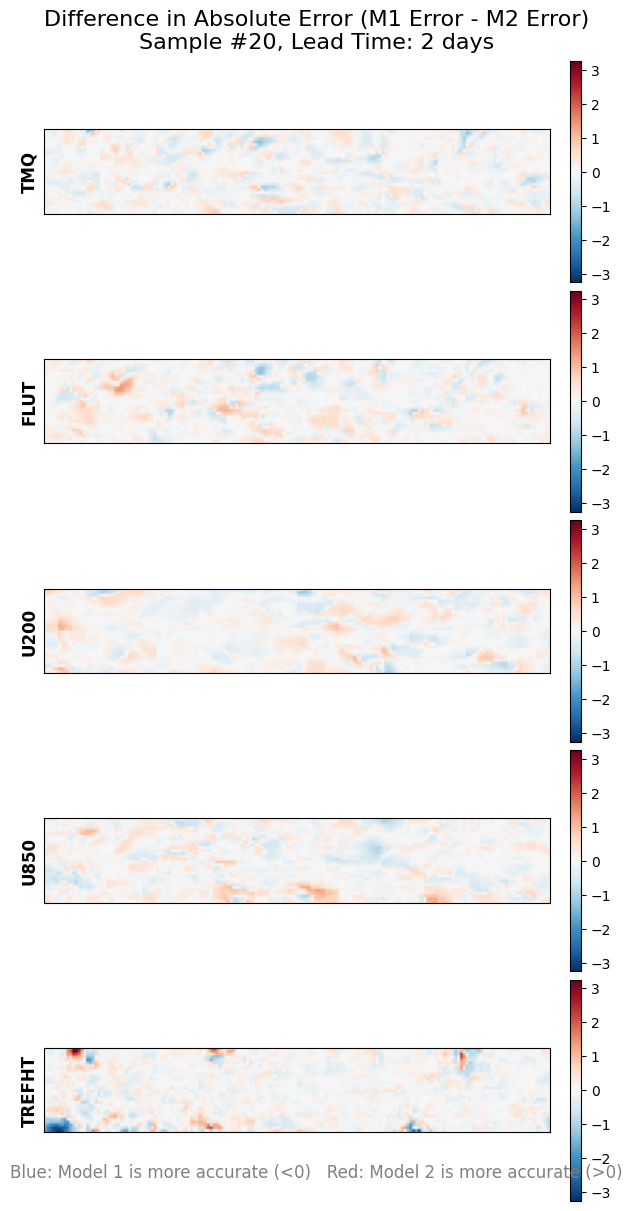

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os # Make sure os is imported if running in a completely new environment

# --- Assume target_np, predicted_np_1, predicted_np_2 are available from previous cell ---
# --- Also assume variable_names and bcor_directory are available ---

print("\n--- Generating plot of the difference in absolute errors ---")

# 1. Calculate the absolute error for each model
abs_error_m1 = np.abs(predicted_np_1 - target_np)
abs_error_m2 = np.abs(predicted_np_2 - target_np)

# 2. Calculate the difference in absolute errors: (Error_M1 - Error_M2)
# Negative values mean M1 had smaller error (more accurate)
# Positive values mean M2 had smaller error (more accurate)
error_difference = abs_error_m1 - abs_error_m2

# 3. Determine a single, symmetric color scale for all difference plots
max_abs_err_diff = np.max(np.abs(error_difference))

# 4. Create the plot (5 rows, 1 column)
fig, axes = plt.subplots(5, 1, figsize=(6, 12), constrained_layout=True)
fig.suptitle(f'Difference in Absolute Error (M1 Error - M2 Error)\nSample #{sample_idx}, Lead Time: {lead_time_width} days', fontsize=16)

for i in range(5): # Loop through the 5 channels
    # Plot the difference in errors
    im = axes[i].imshow(error_difference[i], cmap='RdBu_r', vmin=-max_abs_err_diff, vmax=max_abs_err_diff)
    fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.05, pad=0.04)
    axes[i].set_ylabel(variable_names[i], fontsize=12, fontweight='bold')

    # Remove ticks for clarity
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Add a text annotation explaining the colors
fig.text(0.5, 0.02, 'Blue: Model 1 is more accurate (<0)   Red: Model 2 is more accurate (>0)',
         ha='center', va='bottom', fontsize=12, color='gray')

plt.savefig(bcor_directory + f"absolute_error_difference_example_lead{lead_time_width}.png")
plt.show()

In [7]:
print(error_difference.mean())

0.0073095076


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from netCDF4 import Dataset
import os
import random
import copy
import csv
import pandas as pd
from ViT_Unpatch import ViT

import xarray as xr

# --------------------
# General Setup
# --------------------

deBug = True
seed_num = 1
np.random.seed(seed_num)
random.seed(seed_num)
torch.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)
torch.cuda.is_available()
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")
model_leadTms = "10-30More_schedulerPlateau"
lead_times_to_load = [10,13,15,18,20,23,25,28,30]

# --------------------
# Data Directories
# --------------------
mdl_directory = "/gpfs/gibbs/project/lu_lu/ax59/MJO_Project/Data/AllLeadTms/"
mdl_out_dir = "Result_01/"
obs_directory = "/gpfs/gibbs/project/lu_lu/ax59/MJO_Project/Data/AllLeadTms/"
obs_out_dir = "Result_02/"
bcor_directory = "Result_03/"
time_dir = "Data/Time/"

file_path = "/gpfs/gibbs/project/lu_lu/ax59/MJO_Project/Data/AllLeadTms/CML2025_Step0C_TROP30_OBS_remapped_90x180_daily_DJFM_Anom_nonFltr_tcwv_leadTm10.nc"

time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
ds = xr.open_dataset(file_path,decode_times=time_coder)

df = ds.to_dataframe().reset_index()

print(ds)
print("Data variables:", list(ds.data_vars))
print("Coordinates:", list(ds.coords))

<xarray.Dataset> Size: 110MB
Dimensions:  (time: 5092, lat: 30, lon: 180)
Coordinates:
  * time     (time) object 41kB 1980-11-21 12:00:00 ... 2022-03-21 12:00:00
  * lat      (lat) float64 240B -29.0 -27.0 -25.0 -23.0 ... 23.0 25.0 27.0 29.0
  * lon      (lon) float64 1kB 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
Data variables:
    tcwv     (time, lat, lon) float32 110MB -0.4326 -0.4867 ... 0.2903 0.3059
Data variables: ['tcwv']
Coordinates: ['time', 'lat', 'lon']


In [7]:
print(ds['time'][20])

<xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeGregorian(1980, 12, 11, 12, 0, 0, 0, has_year_zero=False),
      dtype=object)
Coordinates:
    time     object 8B 1980-12-11 12:00:00
Attributes:
    long_name:     time
    cell_methods:  time: mean


In [8]:
print(ds['time'][22])

<xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeGregorian(1980, 12, 13, 12, 0, 0, 0, has_year_zero=False),
      dtype=object)
Coordinates:
    time     object 8B 1980-12-13 12:00:00
Attributes:
    long_name:     time
    cell_methods:  time: mean


In [ ]:
# --------------------
# Section 3: Plot a Comparison of Model Errors (Grouped)
# --------------------
print("\n--- Generating a comparison plot of model errors vs. ground truth ---")

# 1. Load the two trained models
model_path_1 = obs_out_dir + f"ViTTIMJO_FiLM_Andrew_OBS_leadTm{model_leadTms}_ensm{seed_num}_round1.pth"
model_path_2 = obs_out_dir + f"ViTTIMJO_FiLM_Andrew_OBS_leadTmFullField2_ensm{seed_num}_round1.pth"

if os.path.exists(model_path_1) and os.path.exists(model_path_2):
    model_1 = torch.load(model_path_1, weights_only=False, map_location=device)
    model_1.eval()
    print(f"Loaded Model 1 from {model_path_1}")

    model_2 = torch.load(model_path_2, weights_only=False, map_location=device)
    model_2.eval()
    print(f"Loaded Model 2 from {model_path_2}")

    # 2. Get a single data sample
    test_dataloader_for_plot = train_val_test_rounds[0][2]
    sample_idx = 20
    input_image, target_image = test_dataloader_for_plot.dataset[sample_idx]

    # 3. Make predictions
    with torch.no_grad():
        input_tensor = input_image.unsqueeze(0).to(device)
        predicted_tensor_1 = model_1(input_tensor)
        predicted_image_1 = predicted_tensor_1.squeeze(0).cpu()
        predicted_tensor_2 = model_2(input_tensor)
        predicted_image_2 = predicted_tensor_2.squeeze(0).cpu()

    # 4. Prepare data for plotting
    target_np = target_image.numpy()
    predicted_np_1 = predicted_image_1.numpy()
    predicted_np_2 = predicted_image_2.numpy()

    # Calculate the error for each model relative to the ground truth
    error_np_1 = predicted_np_1 - target_np
    error_np_2 = predicted_np_2 - target_np

    variable_names = ["TMQ", "FLUT", "U200", "U850", "TREFHT"]

    # Calculate a single, global color scale for both error plots
    global_max_abs_error = np.max(np.abs(np.concatenate([error_np_1, error_np_2])))

    # Create a 5x5 grid
    fig, axes = plt.subplots(5, 5, figsize=(25, 12), constrained_layout=True)
    fig.suptitle(f'Model Error Comparison for Sample #{sample_idx} (Lead Time: {lead_time_width} days)', fontsize=16)

    for i in range(5): # Loop through the 5 channels
        # Determine a common color scale for the physical fields
        vmin = min(target_np[i].min(), predicted_np_1[i].min(), predicted_np_2[i].min())
        vmax = max(target_np[i].max(), predicted_np_1[i].max(), predicted_np_2[i].max())

        # Column 0: Ground Truth
        axes[i, 0].imshow(target_np[i], cmap='jet')
        axes[i, 0].set_ylabel(variable_names[i], fontsize=12, fontweight='bold')

        # Column 1: Model 1 Prediction
        
        axes[i, 1].imshow(predicted_np_1[i], cmap='jet')

        # Column 2: Model 2 Prediction
        im_pred2 = axes[i, 2].imshow(predicted_np_2[i], cmap='jet')
        
        # Add a shared colorbar for the first 3 plots
        fig.colorbar(im_pred2, ax=axes[i, :3].tolist(), orientation='vertical', fraction=0.05, pad=0.04)
        
        # Column 3: Model 1 Error
        im_err1 = axes[i, 3].imshow(error_np_1[i], cmap='jet')
        fig.colorbar(im_err1, ax=axes[i, 3])
        
        # Column 4: Model 2 Error
        im_err2 = axes[i, 4].imshow(error_np_2[i], cmap='jet')
        fig.colorbar(im_err2, ax=axes[i, 4])

    # Set titles for the reordered column layout
    axes[0, 0].set_title("Ground Truth", fontsize=14)
    axes[0, 1].set_title("Model 1 Prediction", fontsize=14)
    axes[0, 2].set_title("Model 2 Prediction", fontsize=14)
    axes[0, 3].set_title("Error (M1 - Truth)", fontsize=14)
    axes[0, 4].set_title("Error (M2 - Truth)", fontsize=14)

    # Remove ticks for clarity
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.savefig(bcor_directory + f"model_error_comparison_grouped_example_lead{lead_time_width}.png")
    plt.show()

else:
    print(f"Could not find one or both trained models. Please ensure both exist:")
    print(f"Model 1: {model_path_1}")
    print(f"Model 2: {model_path_2}")

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from netCDF4 import Dataset
#from vit_pytorch import ViT
import os
import random
import copy
import csv
import pandas as pd
from ViT_Unpatch import ViT

# --------------------
# General Setup
# --------------------

deBug = True
seed_num = 1
np.random.seed(seed_num)
random.seed(seed_num)
torch.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)
torch.cuda.is_available()
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")
model_leadTms = "FullField2"
lead_time_width = 2

# --------------------
# Data Directories
# --------------------
mdl_directory = "/gpfs/gibbs/project/lu_lu/ax59/MJO_Project/Data/AllLeadTms/"
mdl_out_dir = "Result_01/"
obs_directory = "/gpfs/gibbs/project/lu_lu/ax59/MJO_Project/Data/AllLeadTms/"
obs_out_dir = "Result_02/"
bcor_directory = "Result_03/"
time_dir = "Data/Time/"

# --------------------
# Section 1: MDL Training
# --------------------

# Load dataset
mdl_dataset = MDLDataset(mdl_dir=mdl_directory, time_dir=time_dir, lead_time=lead_time_width)

# Split into training and testing sets
mdl_total_samples = len(mdl_dataset)
mdl_train_size = int(0.8 * mdl_total_samples) - int(0.8 * mdl_total_samples) % 121
mdl_test_size = mdl_total_samples - mdl_train_size
mdl_train_dataset, mdl_test_dataset = torch.utils.data.random_split(mdl_dataset, [mdl_train_size, mdl_test_size])

# Create DataLoaders
batch_size = 121
train_dataloader = torch.utils.data.DataLoader(mdl_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(mdl_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=4)

print("\n--- Verifying the time link in the DataLoader ---")

# 1. Instantiate the updated dataset
mdl_dataset_with_time = MDLDataset(mdl_dir=mdl_directory, time_dir=time_dir, lead_time=lead_time_width)

# 2. Get a single sample from the dataset
sample_idx_to_check = 100
try:
    # __getitem__ now returns four items
    features, targets, feature_time, target_time = mdl_dataset_with_time[sample_idx_to_check]

    # 3. Print the time values and check the difference
    print(f"\nVerifying time link for sample #{sample_idx_to_check}:")
    print(f"  - Input feature time (days since year 0): {feature_time}")
    print(f"  - Target time (days since year 0):      {target_time}")

    time_difference = target_time - feature_time
    print(f"  - Calculated time difference:             {time_difference} days")
    print(f"  - Expected lead time width:               {lead_time_width} days")

    if time_difference == lead_time_width:
        print("\nVerification successful! The time link is correct. ✅")
    else:
        print("\nVerification FAILED! The time link is incorrect. ❌")

except IndexError:
    print(f"Error: Sample index {sample_idx_to_check} is out of bounds for the dataset.")
except Exception as e:
    print(f"An error occurred: {e}")

NameError: name 'MDLDataset' is not defined


--- Generating a comparison plot of model errors vs. ground truth on MDL data ---
Loading MDL dataset into memory (NumPy arrays)...
MDL dataset loaded. Total samples: 43076


/home/ax59/.conda/envs/mjo_env_1/lib/python3.13/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loaded Model 1 from Result_01/ViTTIMJO_FiLM_Andrew_MDL_leadTmFullField2_ensm1.pth
Loaded Model 2 from Result_01/ViTTIMJO_FiLM_Andrew_MDL_leadTmFullField2SmallPatch_ensm1.pth


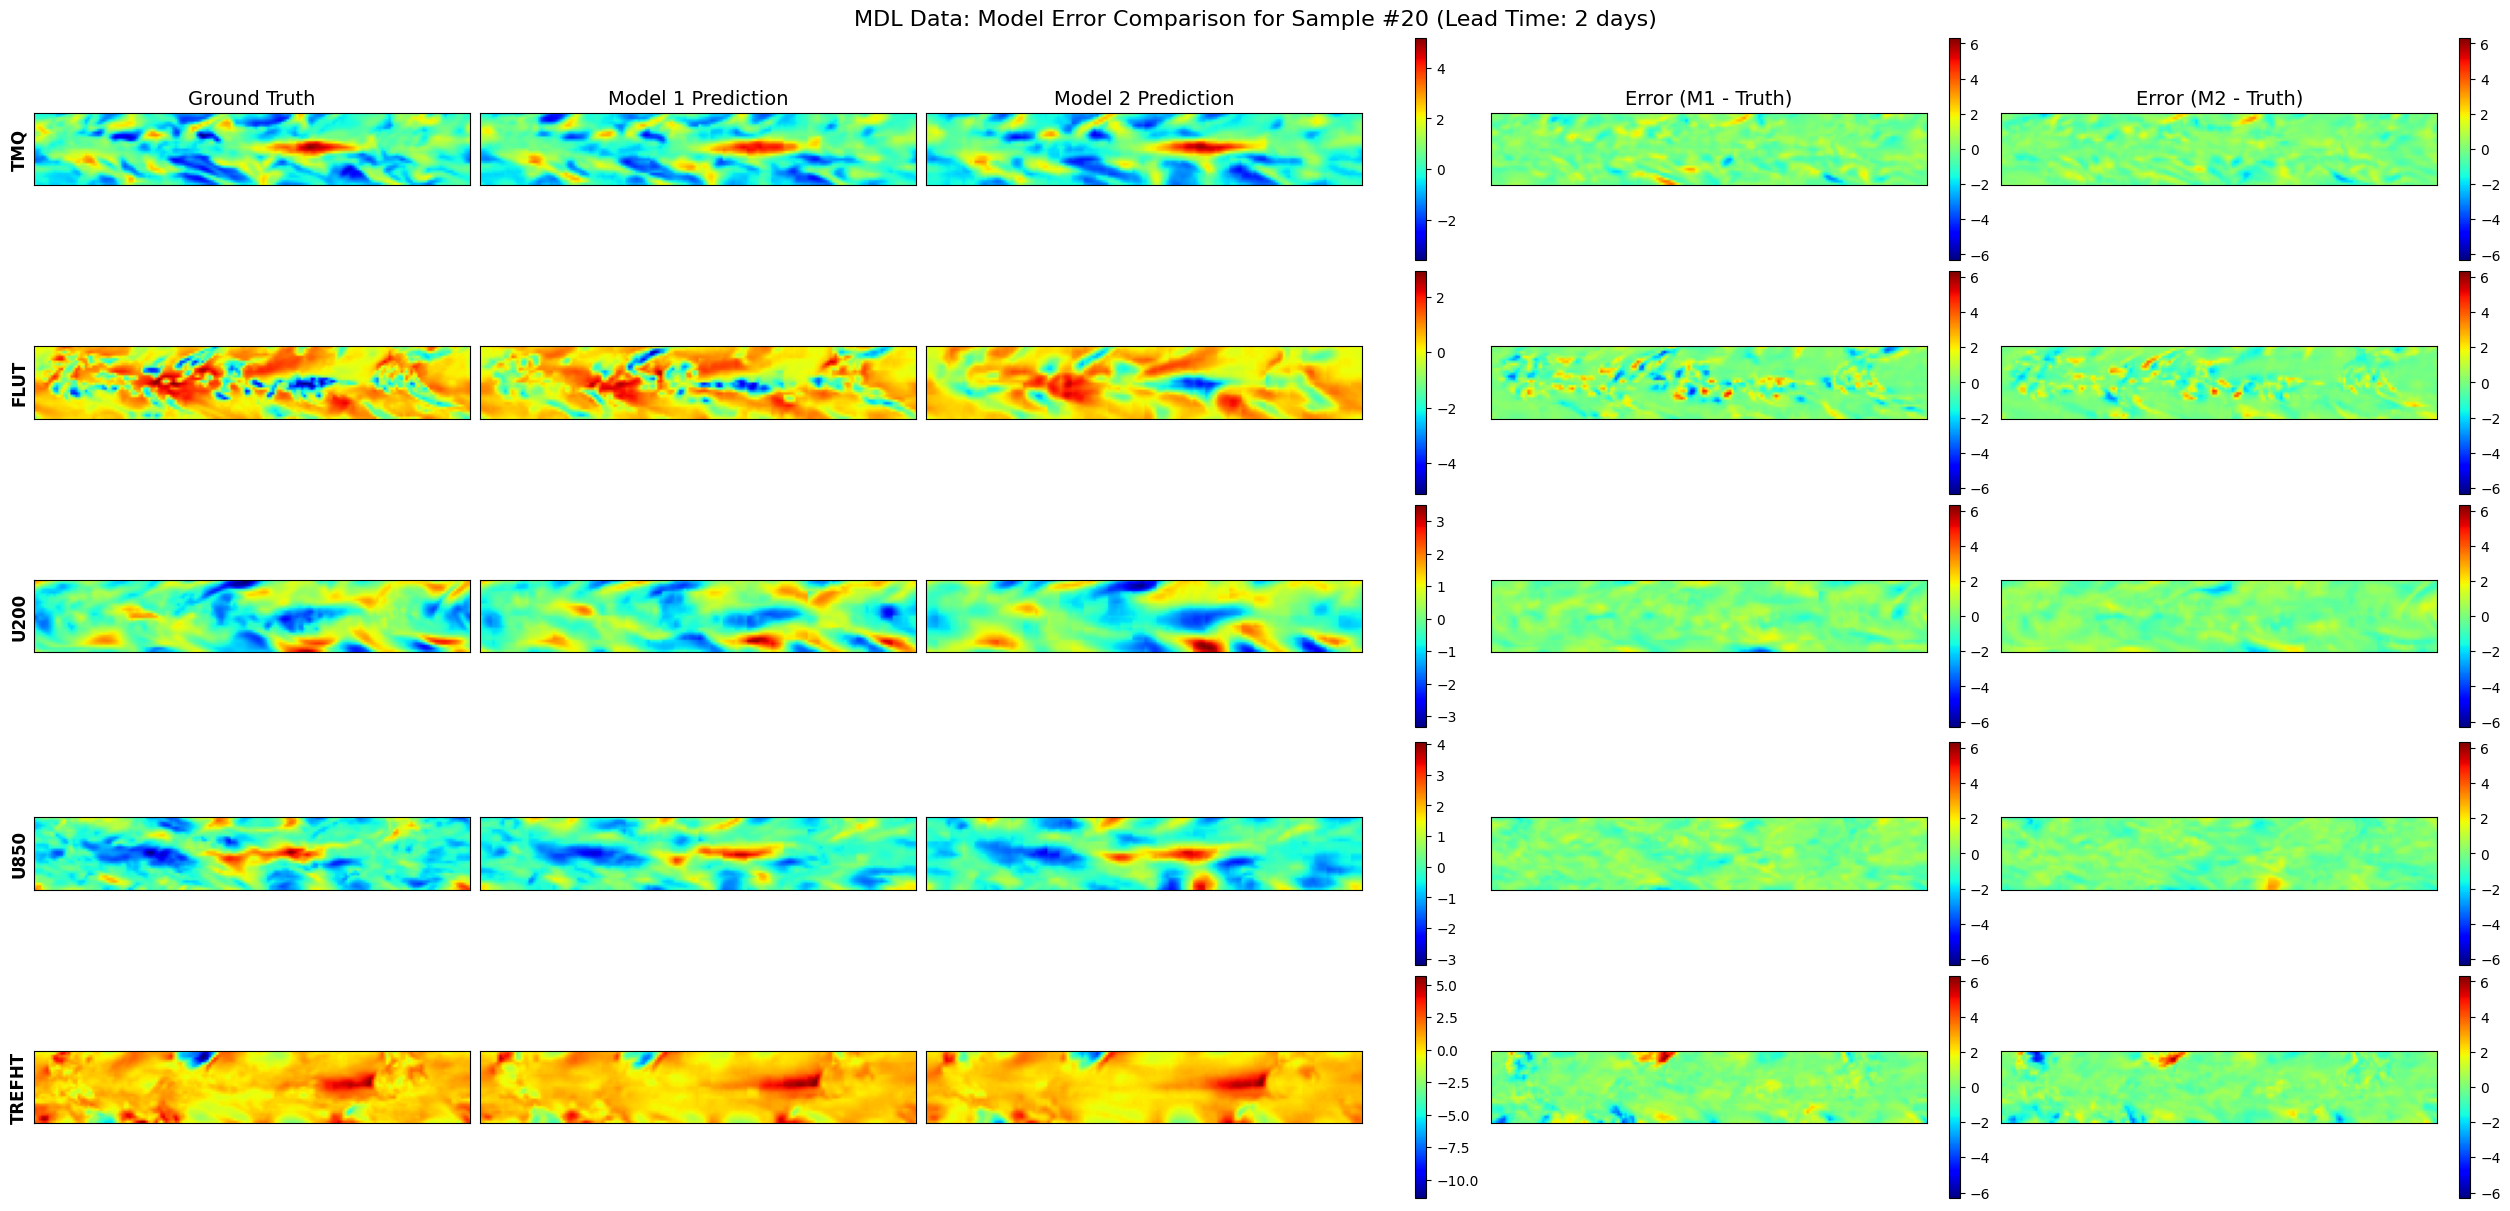

In [5]:
# --------------------
# Section 3: Plot a Comparison of Model Errors on MDL Data
# --------------------
print("\n--- Generating a comparison plot of model errors vs. ground truth on MDL data ---")

# 1. Load the two MDL-trained models you want to compare
#    NOTE: Pointing both paths to the same model.
#    Change model_path_2 if you have a different MDL model to compare.
model_path_1 = mdl_out_dir + f"ViTTIMJO_FiLM_Andrew_MDL_leadTmFullField2_ensm1.pth"
model_path_2 = mdl_out_dir + f"ViTTIMJO_FiLM_Andrew_MDL_leadTmFullField2SmallPatch_ensm1.pth" # CHANGE THIS PATH for a second model

# Load dataset
mdl_dataset = MDLDataset(mdl_dir=mdl_directory, time_dir=time_dir, lead_time=lead_time_width)

# Split into training and testing sets
mdl_total_samples = len(mdl_dataset)
mdl_train_size = int(0.8 * mdl_total_samples) - int(0.8 * mdl_total_samples) % 121
mdl_test_size = mdl_total_samples - mdl_train_size
mdl_train_dataset, mdl_test_dataset = torch.utils.data.random_split(mdl_dataset, [mdl_train_size, mdl_test_size])

# Create DataLoaders
batch_size = 121
train_dataloader = torch.utils.data.DataLoader(mdl_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(mdl_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=4)

if os.path.exists(model_path_1) and os.path.exists(model_path_2):
    model_1 = torch.load(model_path_1, weights_only=False, map_location=device)
    model_1.eval()
    print(f"Loaded Model 1 from {model_path_1}")

    model_2 = torch.load(model_path_2, weights_only=False, map_location=device)
    model_2.eval()
    print(f"Loaded Model 2 from {model_path_2}")

    # 2. Get a single data sample from the MDL test set
    #    Uses the 'test_dataloader' created in the MDL training section
    sample_idx = 20
    input_image, target_image = test_dataloader.dataset[sample_idx]

    # 3. Make predictions
    with torch.no_grad():
        input_tensor = input_image.unsqueeze(0).to(device)
        predicted_tensor_1 = model_1(input_tensor)
        predicted_image_1 = predicted_tensor_1.squeeze(0).cpu()
        predicted_tensor_2 = model_2(input_tensor)
        predicted_image_2 = predicted_tensor_2.squeeze(0).cpu()

    # 4. Prepare data for plotting
    target_np = target_image.numpy()
    predicted_np_1 = predicted_image_1.numpy()
    predicted_np_2 = predicted_image_2.numpy()

    # Calculate the error for each model relative to the ground truth
    error_np_1 = predicted_np_1 - target_np
    error_np_2 = predicted_np_2 - target_np

    variable_names = ["TMQ", "FLUT", "U200", "U850", "TREFHT"]

    # Calculate a single, global color scale for both error plots
    global_max_abs_error = np.max(np.abs(np.concatenate([error_np_1, error_np_2])))

    # Create a 5x5 grid
    fig, axes = plt.subplots(5, 5, figsize=(25, 12), constrained_layout=True)
    fig.suptitle(f'MDL Data: Model Error Comparison for Sample #{sample_idx} (Lead Time: {lead_time_width} days)', fontsize=16)

    for i in range(5): # Loop through the 5 channels
        # Determine a common color scale for the physical fields
        vmin = min(target_np[i].min(), predicted_np_1[i].min(), predicted_np_2[i].min())
        vmax = max(target_np[i].max(), predicted_np_1[i].max(), predicted_np_2[i].max())

        # Column 0: Ground Truth
        axes[i, 0].imshow(target_np[i], cmap='jet', vmin=vmin, vmax=vmax)
        axes[i, 0].set_ylabel(variable_names[i], fontsize=12, fontweight='bold')

        # Column 1: Model 1 Prediction
        axes[i, 1].imshow(predicted_np_1[i], cmap='jet', vmin=vmin, vmax=vmax)

        # Column 2: Model 2 Prediction
        im_pred2 = axes[i, 2].imshow(predicted_np_2[i], cmap='jet', vmin=vmin, vmax=vmax)
        
        # Add a shared colorbar for the first 3 plots
        fig.colorbar(im_pred2, ax=axes[i, :3].tolist(), orientation='vertical', fraction=0.05, pad=0.04)
        
        # Column 3: Model 1 Error
        im_err1 = axes[i, 3].imshow(error_np_1[i], cmap='jet', vmin=-global_max_abs_error, vmax=global_max_abs_error)
        fig.colorbar(im_err1, ax=axes[i, 3])
        
        # Column 4: Model 2 Error
        im_err2 = axes[i, 4].imshow(error_np_2[i], cmap='jet', vmin=-global_max_abs_error, vmax=global_max_abs_error)
        fig.colorbar(im_err2, ax=axes[i, 4])

    # Set titles for the reordered column layout
    axes[0, 0].set_title("Ground Truth", fontsize=14)
    axes[0, 1].set_title("Model 1 Prediction", fontsize=14)
    axes[0, 2].set_title("Model 2 Prediction", fontsize=14)
    axes[0, 3].set_title("Error (M1 - Truth)", fontsize=14)
    axes[0, 4].set_title("Error (M2 - Truth)", fontsize=14)

    # Remove ticks for clarity
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.savefig(bcor_directory + f"mdl_model_error_comparison_grouped_example_lead{lead_time_width}.png")
    plt.show()

else:
    print(f"Could not find one or both MDL trained models. Please ensure both exist:")
    print(f"Model 1: {model_path_1}")
    print(f"Model 2: {model_path_2}")

In [6]:
# --------------------
# Section 3: Plot a Comparison of Model Errors (Grouped)
# --------------------
print("\n--- Generating a comparison plot of model errors vs. ground truth ---")

# 1. Load the two trained models
model_path_1 = obs_out_dir + f"ViTTIMJO_FiLM_Andrew_OBS_leadTm{model_leadTms}_ensm{seed_num}_round1.pth"
model_path_2 = obs_out_dir + f"ViTTIMJO_FiLM_Andrew_OBS_leadTmFullField2_ensm{seed_num}_round1.pth"

if os.path.exists(model_path_1) and os.path.exists(model_path_2):
    model_1 = torch.load(model_path_1, weights_only=False, map_location=device)
    model_1.eval()
    print(f"Loaded Model 1 from {model_path_1}")

    model_2 = torch.load(model_path_2, weights_only=False, map_location=device)
    model_2.eval()
    print(f"Loaded Model 2 from {model_path_2}")

    # 2. Get a single data sample
    test_dataloader_for_plot = train_val_test_rounds[0][2]
    sample_idx = 20
    input_image, target_image = test_dataloader_for_plot.dataset[sample_idx]

    # 3. Make predictions
    with torch.no_grad():
        input_tensor = input_image.unsqueeze(0).to(device)
        predicted_tensor_1 = model_1(input_tensor)
        predicted_image_1 = predicted_tensor_1.squeeze(0).cpu()
        predicted_tensor_2 = model_2(input_tensor)
        predicted_image_2 = predicted_tensor_2.squeeze(0).cpu()

    # 4. Prepare data for plotting
    target_np = target_image.numpy()
    predicted_np_1 = predicted_image_1.numpy()
    predicted_np_2 = predicted_image_2.numpy()

    # Calculate the error for each model relative to the ground truth
    error_np_1 = predicted_np_1 - target_np
    error_np_2 = predicted_np_2 - target_np

    variable_names = ["TMQ", "FLUT", "U200", "U850", "TREFHT"]

    # Calculate a single, global color scale for both error plots
    global_max_abs_error = np.max(np.abs(np.concatenate([error_np_1, error_np_2])))

    # Create a 5x5 grid
    fig, axes = plt.subplots(5, 5, figsize=(25, 12), constrained_layout=True)
    fig.suptitle(f'Model Error Comparison for Sample #{sample_idx} (Lead Time: {lead_time_width} days)', fontsize=16)

    for i in range(5): # Loop through the 5 channels
        # Determine a common color scale for the physical fields
        vmin = min(target_np[i].min(), predicted_np_1[i].min(), predicted_np_2[i].min())
        vmax = max(target_np[i].max(), predicted_np_1[i].max(), predicted_np_2[i].max())

        # Column 0: Ground Truth
        axes[i, 0].imshow(target_np[i], cmap='jet')
        axes[i, 0].set_ylabel(variable_names[i], fontsize=12, fontweight='bold')

        # Column 1: Model 1 Prediction
        
        axes[i, 1].imshow(predicted_np_1[i], cmap='jet')

        # Column 2: Model 2 Prediction
        im_pred2 = axes[i, 2].imshow(predicted_np_2[i], cmap='jet')
        
        # Add a shared colorbar for the first 3 plots
        fig.colorbar(im_pred2, ax=axes[i, :3].tolist(), orientation='vertical', fraction=0.05, pad=0.04)
        
        # Column 3: Model 1 Error
        im_err1 = axes[i, 3].imshow(error_np_1[i], cmap='jet')
        fig.colorbar(im_err1, ax=axes[i, 3])
        
        # Column 4: Model 2 Error
        im_err2 = axes[i, 4].imshow(error_np_2[i], cmap='jet')
        fig.colorbar(im_err2, ax=axes[i, 4])

    # Set titles for the reordered column layout
    axes[0, 0].set_title("Ground Truth", fontsize=14)
    axes[0, 1].set_title("Model 1 Prediction", fontsize=14)
    axes[0, 2].set_title("Model 2 Prediction", fontsize=14)
    axes[0, 3].set_title("Error (M1 - Truth)", fontsize=14)
    axes[0, 4].set_title("Error (M2 - Truth)", fontsize=14)

    # Remove ticks for clarity
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.savefig(bcor_directory + f"model_error_comparison_grouped_example_lead{lead_time_width}.png")
    plt.show()

else:
    print(f"Could not find one or both trained models. Please ensure both exist:")
    print(f"Model 1: {model_path_1}")
    print(f"Model 2: {model_path_2}")


--- Generating a comparison plot of model errors vs. ground truth ---
Loaded Model 1 from Result_02/ViTTIMJO_FiLM_Andrew_OBS_leadTmFullField2SmallPatch_ensm1_round1.pth
Loaded Model 2 from Result_02/ViTTIMJO_FiLM_Andrew_OBS_leadTmFullField2_ensm1_round1.pth


NameError: name 'train_val_test_rounds' is not defined

In [20]:
import pandas as pd
from netCDF4 import Dataset, num2date
import numpy as np
import os
import sys

print("--- Starting Diagnostic Script for MDL Time Data ---")

# --- 1. Define File Path ---
# We only need to check one file, since the time dim is assumed to be the same
mdl_dir = "/gpfs/gibbs/project/lu_lu/ax59/MJO_Project/Data/AllLeadTms/"
var_name = "TMQ" # Let's check the file you get time from
file_path = os.path.join(mdl_dir, f"CML2025_Step0C_TROP30_MDL_remapped_90x180_daily_DJFM_Anom_nonFltr_{var_name}_leadTm1.nc")

print(f"Loading time data from: {file_path}")

try:
    # --- 2. Load Raw Time Data ---
    with Dataset(file_path) as f:
        if 'time' not in f.variables:
            print(f"Error: 'time' variable not found in file.", file=sys.stderr)
        else:
            time_var = f.variables['time']
            time_values = time_var[:]
            time_units = time_var.units
            time_calendar = time_var.calendar
            
            # Convert to datetime objects
            raw_datetime_objects = num2date(time_values, units=time_units, calendar=time_calendar)
            print(f"\nSuccessfully loaded {len(raw_datetime_objects)} total time entries.")

            # --- 3. Analyze Duplicates with Pandas ---
            # This is the most powerful way to see what's going on
            time_series = pd.Series(raw_datetime_objects)
            
            print("\n--- Analyzing Date Frequencies ---")
            date_counts = time_series.value_counts()
            
            print(f"Total entries:     {len(time_series)}")
            print(f"Unique dates:      {len(date_counts)}")
            print(f"Duplicate entries: {len(time_series) - len(date_counts)}")
            
            if len(date_counts) > 0:
                print("\nTop 10 most common dates found:")
                print(date_counts.head(10))
                
                avg_count = date_counts.mean()
                if date_counts.iloc[0] > 1:
                    print(f"\nHypothesis: The data appears to be in an ensemble format.")
                    print(f"For example, the date {date_counts.index[0].strftime('%Y-%m-%d')} appears {date_counts.iloc[0]} times.")
                    print(f"The average date count is: {avg_count:.2f}")

            # --- 4. Look at the Raw, Unsorted Order ---
            print("\n--- First 50 Entries (Raw Order from File) ---")
            for i in range(min(50, len(raw_datetime_objects))):
                print(f"Index {i}: {raw_datetime_objects[i].strftime('%Y-%m-%d')}")

except Exception as e:
    print(f"\nAn error occurred during the diagnostic: {e}", file=sys.stderr)

print("\n--- Diagnostic Script Finished ---")

--- Starting Diagnostic Script for MDL Time Data ---
Loading time data from: /gpfs/gibbs/project/lu_lu/ax59/MJO_Project/Data/AllLeadTms/CML2025_Step0C_TROP30_MDL_remapped_90x180_daily_DJFM_Anom_nonFltr_TMQ_leadTm1.nc

Successfully loaded 43076 total time entries.

--- Analyzing Date Frequencies ---
Total entries:     43076
Unique dates:      13189
Duplicate entries: 29887

Top 10 most common dates found:
0001-11-30 00:00:00    8
0001-12-01 00:00:00    8
0001-12-02 00:00:00    8
0001-12-03 00:00:00    8
0001-12-04 00:00:00    8
0001-12-05 00:00:00    8
0001-12-06 00:00:00    8
0001-12-07 00:00:00    8
0001-12-08 00:00:00    8
0001-12-09 00:00:00    8
Name: count, dtype: int64

Hypothesis: The data appears to be in an ensemble format.
For example, the date 0001-11-30 appears 8 times.
The average date count is: 3.27

--- First 50 Entries (Raw Order from File) ---
Index 0: 0001-11-30
Index 1: 0001-12-01
Index 2: 0001-12-02
Index 3: 0001-12-03
Index 4: 0001-12-04
Index 5: 0001-12-05
Index 6

In [21]:
import pandas as pd
from netCDF4 import Dataset
import numpy as np
import os
import sys

print("--- Starting New Diagnostic: What is in the MDL file? ---")

# --- 1. Define File Path ---
mdl_dir = "/gpfs/gibbs/project/lu_lu/ax59/MJO_Project/Data/AllLeadTms/"
var_name = "TMQ"
file_path = os.path.join(mdl_dir, f"CML2025_Step0C_TROP30_MDL_remapped_90x180_daily_DJFM_Anom_nonFltr_{var_name}_leadTm1.nc")

print(f"Loading metadata from: {file_path}\n")

try:
    with Dataset(file_path) as f:
        
        # --- 1. Print all Dimensions ---
        print("--- Dimensions in file ---")
        for dimname, dimobj in f.dimensions.items():
            print(f"  - {dimname}: {len(dimobj)}")

        # --- 2. Print all Variables and their shape/type ---
        print("\n--- Variables in file (and their shapes) ---")
        for varname, varobj in f.variables.items():
            print(f"  - {varname}: {varobj.dtype} {varobj.shape}")

        # --- 3. Check for specific clues ---
        # If the file has a lead_time or ensemble coordinate, 
        # let's look at its first and last 10 values.
        
        potential_clues = ['lead_time', 'ensemble', 'member', 'forecast_time']
        for clue in potential_clues:
            if clue in f.variables:
                print(f"\n--- Found potential clue: '{clue}' ---")
                var_data = f.variables[clue][:]
                print(f"  Data for '{clue}':")
                print(f"  First 10 values: {var_data[:10]}")
                print(f"  Last 10 values: {var_data[-10:]}")
                unique_vals = np.unique(var_data)
                print(f"  Unique values ({len(unique_vals)}): {unique_vals}")

except Exception as e:
    print(f"\nAn error occurred during the diagnostic: {e}", file=sys.stderr)

print("\n--- Diagnostic Script Finished ---")

--- Starting New Diagnostic: What is in the MDL file? ---
Loading metadata from: /gpfs/gibbs/project/lu_lu/ax59/MJO_Project/Data/AllLeadTms/CML2025_Step0C_TROP30_MDL_remapped_90x180_daily_DJFM_Anom_nonFltr_TMQ_leadTm1.nc

--- Dimensions in file ---
  - time: 43076
  - lat: 30
  - lon: 180

--- Variables in file (and their shapes) ---
  - time: float64 (43076,)
  - TMQ: float32 (43076, 30, 180)
  - lat: float64 (30,)
  - lon: float64 (180,)

--- Diagnostic Script Finished ---
